In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_datasets as С
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

#import Tensorflow_examples.models
tf.config.experimental.set_visible_devices([], 'GPU')

 Загрузка датасета



In [5]:
dataset, info = tfds.load('lost_and_found', with_info=True)


In [1]:
dataset['train']

NameError: name 'dataset' is not defined

In [ ]:
dataset['test']

<_PrefetchDataset element_spec={'image_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image_left': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None), 'segmentation_label': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None)}>

Следующий код выполнит простую аугументацию данных посредством переворота изображений. В дополнение изображение будет нормализовано к 0 и 1. Пиксели сегментационной маски будут помечены {1, 2, 3}, но для удобства из данного цифрового ряда будет вычтено по 1 и в итоге получиться {0, 1, 2}

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  for img in datapoint:
    input_image = tf.image.resize(datapoint['image_left'], (224, 224,), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_mask = tf.image.resize(datapoint['segmentation_label'], (224, 224), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)

    # input_image = normalize(input_image)

  return input_image , input_mask

In [ ]:
# def load_image_test(datapoint):
#   input_image = tf.image.resize(datapoint['image_left'], (128, 128, 3))
#   input_mask = tf.image.resize(datapoint['segmentation_label'], (128, 128))
#   input_image, input_mask = normalize(input_image, input_mask)
#   return input_image, input_mask

In [ ]:
@tf.function
def load_image_test(datapoint):
  for img in datapoint:
    input_image = tf.image.resize(datapoint['image_left'], (224, 224,), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_mask = tf.image.resize(datapoint['segmentation_label'], (224, 224), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)

    # input_image = normalize(input_image)

  return input_image , input_mask

Датасет уже содержит необходимые тестовый и тренеровочный сплиты, поэтому давайте использовать их.

In [ ]:
import pandas as pd
row_lens = []
col_lens = []
for img in dataset['train']:
  row_lens.append(int(img['image_left'].shape[0]))
  col_lens.append(int(img['image_left'].shape[1]))
t = pd.DataFrame(row_lens, columns=['rows'])
t['cols'] = col_lens

NameError: name 'dataset' is not defined

In [ ]:
images = []
for img in dataset['train']:
  single_img = img['image_left']
  images.append(single_img)

NameError: name 'dataset' is not defined

In [ ]:
images[1].shape

IndexError: list index out of range

In [ ]:
plt.imshow(images[3])
plt.show()

IndexError: list index out of range

In [ ]:
t = tf.image.resize(images[2], (224, 224, ), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
plt.imshow(t[:,:,:])
plt.show()

IndexError: list index out of range

In [ ]:
t.shape

TensorShape([224, 224, 3])

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
load_image_train
load_image_test

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
dataset

{'train': <_PrefetchDataset element_spec={'image_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image_left': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None), 'segmentation_label': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None)}>,
 'test': <_PrefetchDataset element_spec={'image_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image_left': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None), 'segmentation_label': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None)}>}

In [ ]:
train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.uint8, name=None))>

Давайте посмотрим на пример  изображения из датасета и соотвествующую ему маску из датасета.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.uint8, name=None))>

In [ ]:
def display_images(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i][:,:,:])
    plt.axis('off')

plt.show()



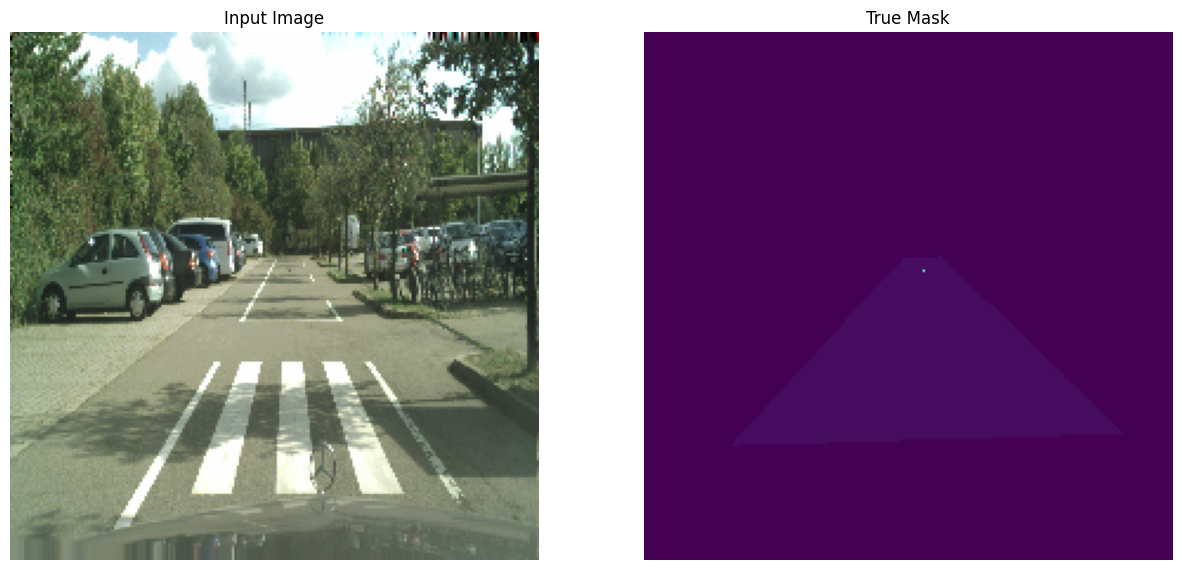

In [ ]:
for image in train.take(1):
	sample_image= image
	display_list = sample_image

display_images(display_list)

In [ ]:
import os
import seaborn as sns
from tensorflow import keras
import cv2
import PIL
from IPython.display import clear_output

In [ ]:
width, height = 224, 224
# width, height = 240, 320

Определение модели



In [ ]:
base_model = keras.applications.vgg16.VGG16(
    include_top=False, input_shape=(width, height, 3))

layer_names = [
    'block1_pool',
    'block2_pool',
    'block3_pool',
    'block4_pool',
    'block5_pool',
]
base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input,
                               base_model_outputs)

In [ ]:
def fcn8_decoder(convs, n_classes):
	f1, f2, f3, f4, p5 = convs

	n = 4096
	c6 = tf.keras.layers.Conv2D(
		n, (7, 7), activation='relu', padding='same',
	name="conv6")(p5)
	c7 = tf.keras.layers.Conv2D(
		n, (1, 1), activation='relu', padding='same',
	name="conv7")(c6)

	f5 = c7

	# upsample the output of the encoder
	# then crop extra pixels that were introduced
	o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
		4, 4), strides=(2, 2), use_bias=False)(f5)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 4 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f4
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 4 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample the resulting tensor of the operation you just did
	o = (tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(4, 4), strides=(2, 2),
	use_bias=False))(o)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 3 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f3
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 3 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample up to the size of the original image
	o = tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(8, 8), strides=(8, 8),
	use_bias=False)(o)

	# append a softmax to get the class probabilities
	o = tf.keras.layers.Activation('softmax')(o)
	return o


In [ ]:
def segmentation_model():

	inputs = keras.layers.Input(shape=(width, height, 3))
	convs = VGG_16(inputs)
	outputs = fcn8_decoder(convs, 3)
	model = tf.keras.Model(inputs=inputs, outputs=outputs)

	return model


opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
			loss=tf.keras.losses.SparseCategoricalCrossentropy(
				from_logits=True),
			metrics=['accuracy'])


In [ ]:
def create_mask(pred_mask):
	pred_mask = tf.argmax(pred_mask, axis=-1)
	pred_mask = pred_mask[..., tf.newaxis]
	return pred_mask[0]


# def show_predictions(dataset=None, num=1):
# 	if dataset:
# 		for image, mask in dataset.take(num):
# 			pred_mask = model.predict(image)
# 			display_images([image[0], mask[0], create_mask(pred_mask)])
# 	else:
# 		# display_images([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
# 		display_images([sample_image, sample_image, create_mask(model.predict(sample_image[tf.newaxis, ...]))])


# show_predictions()


# Обучение  
Теперь, когда все необходимые функции вместе с моделью созданы, мы будем обучать модель. Мы будем обучать модель в течение 20 эпох и выполним разделение проверки на 5.

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_ds, epochs=EPOCHS,
						steps_per_epoch=STEPS_PER_EPOCH,
						validation_steps=VALIDATION_STEPS,
						validation_data=test_ds)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [ ]:
def compute_metrics(y_true, y_pred):
	'''
	Computes IOU and Dice Score.

	Args:
	y_true (tensor) - ground truth label map
	y_pred (tensor) - predicted label map
	'''

	class_wise_iou = []++++++++++++++++++++++++++++++++++++++++++++++++++++
	class_wise_dice_score = []++++++++++++++++++++

	smoothening_factor = 0.00001

	for i in range(3):
		intersection = np.sum((y_pred == i) * (y_true == i))
		y_true_area = np.sum((y_true == i))++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++=+++++++++++++++++=+++++=+++++++++++++++++++++++++++++++++++++++
		y_pred_area = np.sum((y_pred == i))+++++++++++++++++++++
		iou = (intersection + smoothening_factor) / \++++++++++++++++++++++++++++++++++++
			(combined_area - intersection + smoothening_factor)
		class_wise_iou.append(iou)

		dice_score = 2 * ((intersection + smoothening_factor) /
						(combined_area + smoothening_factor))
		class_wise_dice_score.append(dice_score)

	9+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++return class_wise_iou, class_wise_dice_score


In [ ]:
def get_test_image_and_annotation_arrays():
	'''
	Unpacks the test dataset and returns
	the input images and segmentation masks
	'''

	ds = test_ds.unbatch()
	ds = ds.batch(info.splits['test'].num_examples)

	images = []
	y_true_segments = []

	for image, annotation in ds.take(1):
		y_true_segments = annotation.numpy()
		images = image.numpy()

	y_true_segments = y_true_segments[:(
		info.splits['test'].num_examples - (info.splits['test']
											.num_examples % BATCH_SIZE))]
	images = images[:(info.splits['test'].num_examples -
					(info.splits['test'].num_examples % BATCH_SIZE))]

	return images, y_true_segments


y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

integer_slider = 2574
img = np.reshape(y_true_images[integer_slider], (1, width, height, 3))
y_pred_mask = model.predict(img)
y_pred_mask = create_mask(y_pred_mask)
y_pred_mask.shape


def display_prediction(display_list, display_string):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask', 'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
		plt.xticks([])
		plt.yticks([])
		if i == 1:
			plt.xlabel(display_string, fontsize=12)
		plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
	plt.show()


iou, dice_score = compute_metrics(
	y_true_segments[integer_slider], y_pred_mask.numpy())
display_list = [y_true_images[integer_slider],
				y_true_segments[integer_slider], y_pred_mask]

display_string_list = ["{}: IOU: {} Dice Score: {}".format(display_list[idx],
														i, dc) for idx, (i, dc) in
					enumerate(zip(np.round(iou, 4), np.round(dice_score, 4)))]
display_string = "\n\n".join(display_string_list)


# showing predictions with metrics
display_prediction(display_list, display_string)


In [ ]:
OUTPUT_CHANNELS = 3
import tensorflow as tf

Как упоминалось ранее энкодером будет предтренированный MobileNetV2, который подготовлен и готов к использованию - [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). Энкодер состоит из определенных аутпутов из средних слоев модели. Обратите внимание энкодр не будет участвовать в процессе тренировкие модели.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-npjwy81p
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-npjwy81p
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=432e120f751d3d771bee71d0e4e2e52c1100bfb5b463394553fefefeeb5a2316
  Stored in directory: /tmp/pip-ephem-wheel-cache-1zzjshzl/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False



Декодер/апсемплер это просто серия апсемпл блоков имплементированнхы в TensorFlow examples.

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Тренировка модели



In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='SGD',
              loss=tf.keras.losses.KLDivergence(),
              metrics=['top_k_categorical_accuracy'])

Посмотрим на получившуюся архитектуру модели.

In [ ]:
!pip install pydot

In [ ]:
%pip install graphviz

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


Давайте попробуем сделать предсказание с помощью нашей модели до того как началось обучение.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions()



Давайте осуществлять мониторинг того как улучшается работа модели в процессе обучения. Для завершения этой задачи callback функция определена ниже.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Давайте сделаем несколько предсказаний. Для экономии времени использовалось небольшое количество эпох, но вы можете его увеличить для того чтобы модель давала более точные результаты.

In [1]:
show_predictions(test_dataset, 3)

NameError: name 'show_predictions' is not defined

# Домашнее задание №6